In [ ]:
display(output['feature_importance_channel'])
display(output['feature_importance_compartment'])

In [ ]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from math import pi
%matplotlib inline

def interperate_vision_model(settings={}):
    from spacr.io import _read_and_merge_data
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.inspection import permutation_importance
    import shap
    
    def generate_comparison_columns(df, compartments=['cell', 'nucleus', 'pathogen', 'cytoplasm']):

        comparison_dict = {}

        # Get columns by compartment
        compartment_columns = {comp: [col for col in df.columns if col.startswith(comp)] for comp in compartments}

        for comp0, comp0_columns in compartment_columns.items():
            for comp0_col in comp0_columns:
                related_cols = []
                base_col_name = comp0_col.replace(comp0, '')  # Base feature name without compartment prefix

                # Look for matching columns in other compartments
                for prefix, prefix_columns in compartment_columns.items():
                    if prefix == comp0:  # Skip same-compartment comparisons
                        continue
                    # Check if related column exists in other compartment
                    related_col = prefix + base_col_name
                    if related_col in df.columns:
                        related_cols.append(related_col)
                        new_col_name = f"{prefix}_{comp0}{base_col_name}"  # Format: prefix_comp0_base

                        # Calculate ratio and handle infinite or NaN values
                        df[new_col_name] = df[related_col] / df[comp0_col]
                        df[new_col_name].replace([float('inf'), -float('inf')], pd.NA, inplace=True)  # Replace inf values with NA
                        df[new_col_name].fillna(0, inplace=True)  # Replace NaN values with 0 for ease of further calculations

                # Generate all-to-all comparisons
                if related_cols:
                    comparison_dict[comp0_col] = related_cols
                    for i, rel_col_1 in enumerate(related_cols):
                        for rel_col_2 in related_cols[i + 1:]:
                            # Create a new column name for each pairwise comparison
                            comp1, comp2 = rel_col_1.split('_')[0], rel_col_2.split('_')[0]
                            new_col_name_all = f"{comp1}_{comp2}{base_col_name}"

                            # Calculate pairwise ratio and handle infinite or NaN values
                            df[new_col_name_all] = df[rel_col_1] / df[rel_col_2]
                            df[new_col_name_all].replace([float('inf'), -float('inf')], pd.NA, inplace=True)  # Replace inf with NA
                            df[new_col_name_all].fillna(0, inplace=True)  # Replace NaN with 0

        return df, comparison_dict

    def group_feature_class(df, feature_groups=['cell', 'cytoplasm', 'nucleus', 'pathogen'], name='compartment', include_all=False):

        # Function to determine compartment based on multiple matches
        def find_feature_class(feature, compartments):
            matches = [compartment for compartment in compartments if re.search(compartment, feature)]
            if len(matches) > 1:
                return '-'.join(matches)
            elif matches:
                return matches[0]
            else:
                return None

        from spacr.plot import spacrGraph

        df[name] = df['feature'].apply(lambda x: find_feature_class(x, feature_groups))

        if name == 'channel':
            df['channel'].fillna('morphology', inplace=True)

        # Create new DataFrame with summed importance for each compartment and channel
        importance_sum = df.groupby(name)['importance'].sum().reset_index(name=f'{name}_importance_sum')
        
        if include_all:
            total_compartment_importance = importance_sum['importance'].sum()
            importance_sum = pd.concat(
                [importance_sum,
                 pd.DataFrame(
                     [{name: 'all', f'importance': total_compartment_importance}])]
                , ignore_index=True)

        return importance_sum

    # Function to create radar plot for individual and combined values
    def create_extended_radar_plot(values, labels, title):
        values = list(values) + [values[0]]  # Close the loop for radar chart
        angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.plot(angles, values, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=10, rotation=45, ha='right')
        plt.title(title, pad=20)
        plt.show()

    def extract_compartment_channel(feature_name):
        # Identify compartment as the first part before an underscore
        compartment = feature_name.split('_')[0]
        
        if compartment == 'cells':
            compartment = 'cell'

        # Identify channels based on substring presence
        channels = []
        if 'channel_0' in feature_name:
            channels.append('channel_0')
        if 'channel_1' in feature_name:
            channels.append('channel_1')
        if 'channel_2' in feature_name:
            channels.append('channel_2')
        if 'channel_3' in feature_name:
            channels.append('channel_3')

        # If multiple channels are found, join them with a '+'
        if channels:
            channel = ' + '.join(channels)
        else:
            channel = 'morphology'  # Use 'morphology' if no channel identifier is found

        return (compartment, channel)

    def read_and_preprocess_data(settings):

        df, _ = _read_and_merge_data(
            locs=[settings['src']+'/measurements/measurements.db'], 
            tables=settings['tables'], 
            verbose=True, 
            nuclei_limit=settings['nuclei_limit'], 
            pathogen_limit=settings['pathogen_limit']
        )
                
        df, _dict = generate_comparison_columns(df, compartments=['cell', 'nucleus', 'pathogen', 'cytoplasm'])
        print(f"Expanded dataframe to {len(df.columns)} columns with relative features")
        scores_df = pd.read_csv(settings['scores'])

        # Clean and align columns for merging
        df['object_label'] = df['object_label'].str.replace('o', '')

        if 'row_name' not in scores_df.columns:
            scores_df['row_name'] = scores_df['row']

        if 'column_name' not in scores_df.columns:
            if 'column' in scores_df.columns:
                scores_df['column_name'] = scores_df['column']
            elif 'col' in scores_df.columns:
                scores_df['column_name'] = scores_df['col']
                
        if 'object_label' not in scores_df.columns:
            scores_df['object_label'] = scores_df['object']

        # Remove the 'o' prefix from 'object_label' in df, ensuring it is a string type
        df['object_label'] = df['object_label'].str.replace('o', '').astype(str)

        # Ensure 'object_label' in scores_df is also a string
        scores_df['object_label'] = scores_df['object'].astype(str)

        # Ensure all join columns have the same data type in both DataFrames
        df[['plate', 'row_name', 'column_name', 'field', 'object_label']] = df[['plate', 'row_name', 'column_name', 'field', 'object_label']].astype(str)
        scores_df[['plate', 'row_name', 'column_name', 'field', 'object_label']] = scores_df[['plate', 'row_name', 'column_name', 'field', 'object_label']].astype(str)

        # Select only the necessary columns from scores_df for merging
        scores_df = scores_df[['plate', 'row_name', 'column_name', 'field', 'object_label', settings['score_column']]]

        # Now merge DataFrames
        merged_df = pd.merge(df, scores_df, on=['plate', 'row_name', 'column_name', 'field', 'object_label'], how='inner')

        # Separate numerical features and the score column
        X = merged_df.select_dtypes(include='number').drop(columns=[settings['score_column']])
        y = merged_df[settings['score_column']]

        return X, y, merged_df
    
    X, y, merged_df = read_and_preprocess_data(settings)
    
    output = {}
    
    # Step 1: Feature Importance using Random Forest
    if settings['feature_importance'] or settings['shap']:
        model = RandomForestClassifier(random_state=42, n_jobs=settings['n_jobs'])
        model.fit(X, y)
        feature_importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        top_feature_importance_df = feature_importance_df.head(settings['top_features'])
        if settings['feature_importance']:
            print(f"Feature Importance ...")
            plt.figure(figsize=(10, 6))
            plt.barh(top_feature_importance_df['feature'], top_feature_importance_df['importance'])
            plt.xlabel('Importance')
            plt.title(f"Top {settings['top_features']} Features - Feature Importance")
            plt.gca().invert_yaxis()
            plt.show()
                        
        output['feature_importance'] = feature_importance_df
        fi_compartment_df = group_feature_class(feature_importance_df, feature_groups=settings['tables'], name='compartment', include_all=settings['include_all'])
        fi_channel_df = group_feature_class(feature_importance_df, feature_groups=settings['channels'], name='channel', include_all=settings['include_all'])
        
        output['feature_importance_compartment'] = fi_compartment_df
        output['feature_importance_channel'] = fi_channel_df
    
    # Step 2: Permutation Importance
    if settings['permutation_importance']:
        print(f"Permutation Importance ...")
        perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=settings['n_jobs'])
        perm_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
        perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)
        top_perm_importance_df = perm_importance_df.head(settings['top_features'])

        # Plot Permutation Importance
        plt.figure(figsize=(10, 6))
        plt.barh(top_perm_importance_df['feature'], top_perm_importance_df['importance'])
        plt.xlabel('Importance')
        plt.title(f"Top {settings['top_features']} Features - Permutation Importance")
        plt.gca().invert_yaxis()
        plt.show()
        
        output['permutation_importance'] = perm_importance_df
        
        pi_compartment_df = group_feature_class(perm_importance_df, feature_groups=settings['tables'], name='compartment', include_all=settings['include_all'])
        pi_channel_df = group_feature_class(perm_importance_df, feature_groups=settings['channels'], name='channel', include_all=settings['include_all'])
        
        output['permutation_importance_compartment'] = pi_compartment_df
        output['permutation_importance_channel'] = pi_channel_df
    
    # Step 3: SHAP Analysis
    if settings['shap']:
        print(f"SHAP Analysis ...")

        # Select top N features based on Random Forest importance and fit the model on these features only
        top_features = feature_importance_df.head(settings['top_features'])['feature']
        X_top = X[top_features]

        # Refit the model on this subset of features
        model = RandomForestClassifier(random_state=42, n_jobs=settings['n_jobs'])
        model.fit(X_top, y)

        # Sample a smaller subset of rows to speed up SHAP
        if settings['shap_sample']:
            sample = int(len(X_top) / 100)
            X_sample = X_top.sample(min(sample, len(X_top)), random_state=42)
        else:
            X_sample = X_top

        # Initialize SHAP explainer with the same subset of features
        explainer = shap.Explainer(model.predict, X_sample)
        shap_values = explainer(X_sample, max_evals=1500)

        # Plot SHAP summary for the selected sample and top features
        shap.summary_plot(shap_values, X_sample, max_display=settings['top_features'])

        # Convert SHAP values to a DataFrame for easier manipulation
        shap_df = pd.DataFrame(shap_values.values, columns=X_sample.columns)
        
        temp_shap = shap_df.copy()
        output['shap'] = temp_shap
        
        # Apply the function to create MultiIndex columns with compartment and channel
        #shap_df.columns = pd.MultiIndex.from_tuples(
        #    [extract_compartment_channel(feat) for feat in shap_df.columns], 
        #    names=['compartment', 'channel']
        #)
        
        # Aggregate SHAP values by compartment and channel
        #compartment_mean = shap_df.abs().groupby(level='compartment', axis=1).mean().mean(axis=0)
        #channel_mean = shap_df.abs().groupby(level='channel', axis=1).mean().mean(axis=0)

        # Calculate combined importance for each pair of compartments and channels
        #combined_compartment = {}
        #for i, comp1 in enumerate(compartment_mean.index):
        #    for comp2 in compartment_mean.index[i+1:]:
        #        combined_compartment[f"{comp1} + {comp2}"] = shap_df.loc[:, (comp1, slice(None))].abs().mean().mean() + \
        #                                                      shap_df.loc[:, (comp2, slice(None))].abs().mean().mean()
        
        #combined_channel = {}
        #for i, chan1 in enumerate(channel_mean.index):
        #    for chan2 in channel_mean.index[i+1:]:
        #        combined_channel[f"{chan1} + {chan2}"] = shap_df.loc[:, (slice(None), chan1)].abs().mean().mean() + \
        #                                                  shap_df.loc[:, (slice(None), chan2)].abs().mean().mean()

        # Prepare values and labels for radar charts
        #all_compartment_importance = list(compartment_mean.values) + list(combined_compartment.values())
        #all_compartment_labels = list(compartment_mean.index) + list(combined_compartment.keys())

        #all_channel_importance = list(channel_mean.values) + list(combined_channel.values())
        #all_channel_labels = list(channel_mean.index) + list(combined_channel.keys())

        # Create radar plots for compartments and channels
        #create_extended_radar_plot(all_compartment_importance, all_compartment_labels, "SHAP Importance by Compartment (Individual and Combined)")
        #create_extended_radar_plot(all_channel_importance, all_channel_labels, "SHAP Importance by Channel (Individual and Combined)")
        
        #output['shap_1'] = shap_df
        
        #shap_compartment_df = group_feature_class(shap_df, feature_groups=settings['tables'], name='compartment', include_all=settings['include_all'])
        #shap_channel_df = group_feature_class(shap_df, feature_groups=settings['channels'], name='channel', include_all=settings['include_all'])
        
        #output['shap_compartment'] = shap_compartment_df
        #output['shap_channel'] = shap_channel_df
        
    if settings['save']:
        dst = os.path.join(settings['src'], 'results')
        os.makedirs(dst, exist_ok=True)
        for key, df in output.items(): 
            save_path = os.path.join(dst, f"{key}.csv")
            df.to_csv(save_path)
            print(f"Saved {save_path}")
        
    return output

In [ ]:
settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1/datasets/241007_241003_tsg101_screen_plate1_maxvit_t_epoch_99_acc_99.0_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'channels':['channel_0', 'channel_1', 'channel_2', 'channel_3'],
           'include_all':False,
           'feature_importance':True,
           'permutation_importance':False,
           'shap':False,
           'save':True,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

output = interperate_vision_model(settings)

In [ ]:
settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240824_072829/plate2',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240824_072829/plate2/datasets/241007_241007_tsg101_screen_plate2_maxvit_t_epoch_100_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'channels':['channel_0', 'channel_1', 'channel_2', 'channel_3'],
           'include_all':False,
           'feature_importance':True,
           'permutation_importance':False,
           'shap':False,
           'save':True,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

output = interperate_vision_model(settings)

In [ ]:
settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240825_094106/plate3',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240825_094106/plate3/datasets/241008_241008_tsg101_screen_plate3_maxvit_t_epoch_100_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'channels':['channel_0', 'channel_1', 'channel_2', 'channel_3'],
           'include_all':False,
           'feature_importance':True,
           'permutation_importance':False,
           'shap':False,
           'save':True,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

output = interperate_vision_model(settings)

In [ ]:
settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240826_140251/plate4',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240826_140251/plate4/datasets/241008_241008_tsg101_screen_plate4_maxvit_t_epoch_100_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'channels':['channel_0', 'channel_1', 'channel_2', 'channel_3'],
           'include_all':False,
           'feature_importance':True,
           'permutation_importance':False,
           'shap':False,
           'save':True,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

output = interperate_vision_model(settings)

In [ ]:
display(output['feature_importance'])

In [ ]:
from spacr.plot import spacrGraph
%matplotlib inline

spacr_graph = spacrGraph(
    df=output['feature_importance_compartment'],                                     
    grouping_column='compartment',                         
    data_column='compartment_importance_sum',         
    graph_type='jitter_bar',          
    graph_name='test',          
    summary_func='mean',                         
    colors=None,                                
    output_dir=None,                              
    save=None,                       
    y_lim=None,                     
    error_bar_type='std',                       
    representation='object',
    theme='pastel',                    
)


# Create the plot
spacr_graph.create_plot()

# Get the figure object if needed
fig = spacr_graph.get_figure()
plt.show()

In [ ]:
from spacr.plot import spacrGraph
%matplotlib inline

spacr_graph = spacrGraph(
    df=output['feature_importance_compartment'],                                     
    grouping_column='compartment',                         
    data_column='compartment_importance_sum',         
    graph_type='jitter_bar',          
    graph_name='test',          
    summary_func='mean',                         
    colors=None,                                
    output_dir=None,                              
    save=None,                       
    y_lim=None,                     
    error_bar_type='std',                       
    representation='object',
    theme='pastel',                    
)


# Create the plot
spacr_graph.create_plot()

# Get the figure object if needed
fig = spacr_graph.get_figure()
plt.show()

In [ ]:
df = output['feature_importance']

# Define compartments using regex patterns
df['compartment'] = df['feature'].apply(lambda x: 'cell' if 'cell' in x else 'nucleus' if 'nucleus' in x else 'cytoplasm' if 'cytoplasm' in x else 'pathogen' if 'pathogen' in x else None)

display(df)

In [ ]:
settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1/datasets/241007_241003_tsg101_screen_plate1_maxvit_t_epoch_99_acc_99.0_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'feature_importance':True,
           'permutation_importance':False,
           'shap':True,
           'save':False,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

merged_df = interperate_vision_model(settings)
display(merged_df)

In [ ]:
for col in merged_df.columns:
    print(col)

Models already downloaded to: /home/carruthers/anaconda3/envs/spacr/lib/python3.9/site-packages/spacr/resources/models


,Key,Value
0,src,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...
1,scores,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...
2,tables,"[cell, nucleus, pathogen, cytoplasm]"
3,feature_importance,True
4,permutation_importance,False
5,shap,True
6,save,False
7,nuclei_limit,1000
8,pathogen_limit,1000
9,top_features,30


cell: 60816
nucleus: 80889
pathogen: 111317
cytoplasm: 60816
cells: 60816, cells grouped: 60816
cytoplasms: 60816, cytoplasms grouped: 60816
nucleus: 80889, nucleus grouped: 60816
pathogens: 111317, pathogens grouped: 60816
Generated dataframe with: 779 columns and 60816 rows
Feature Importance ...


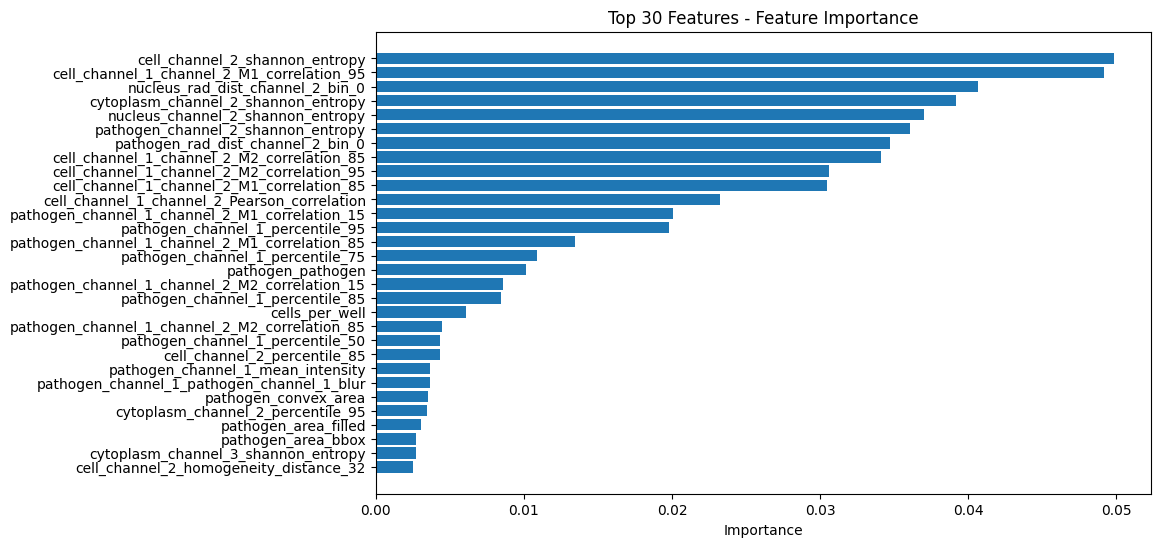

SHAP Analysis ...


PermutationExplainer explainer: 609it [04:02,  2.42it/s]                                                                            


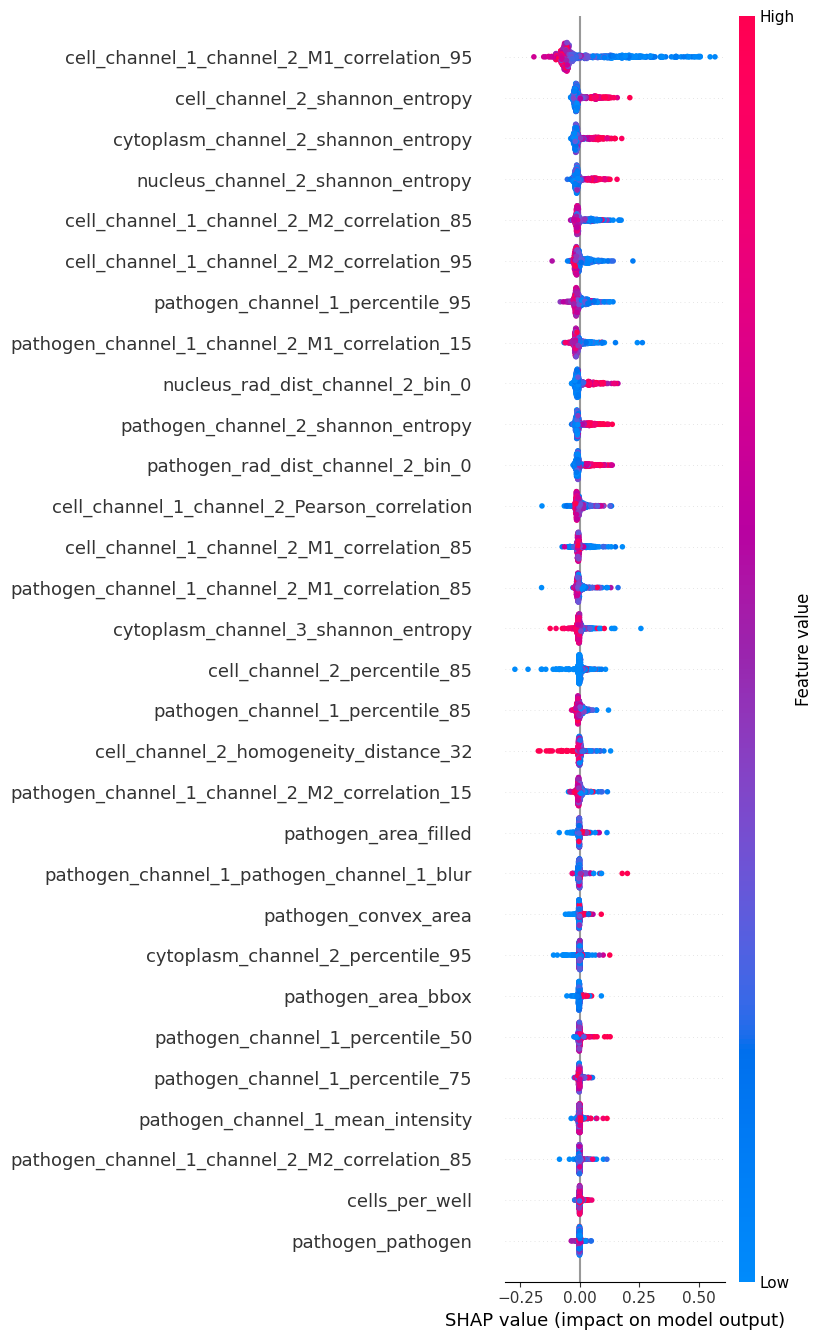

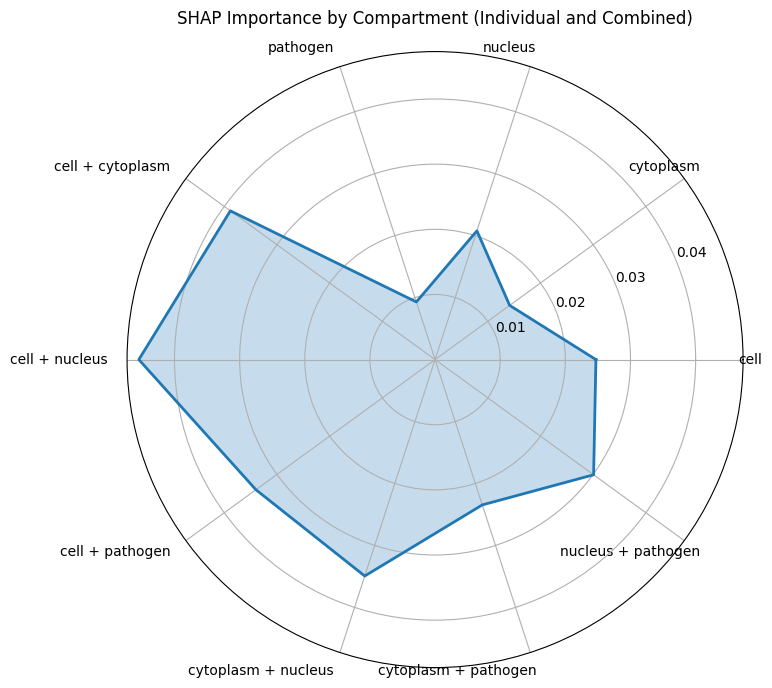

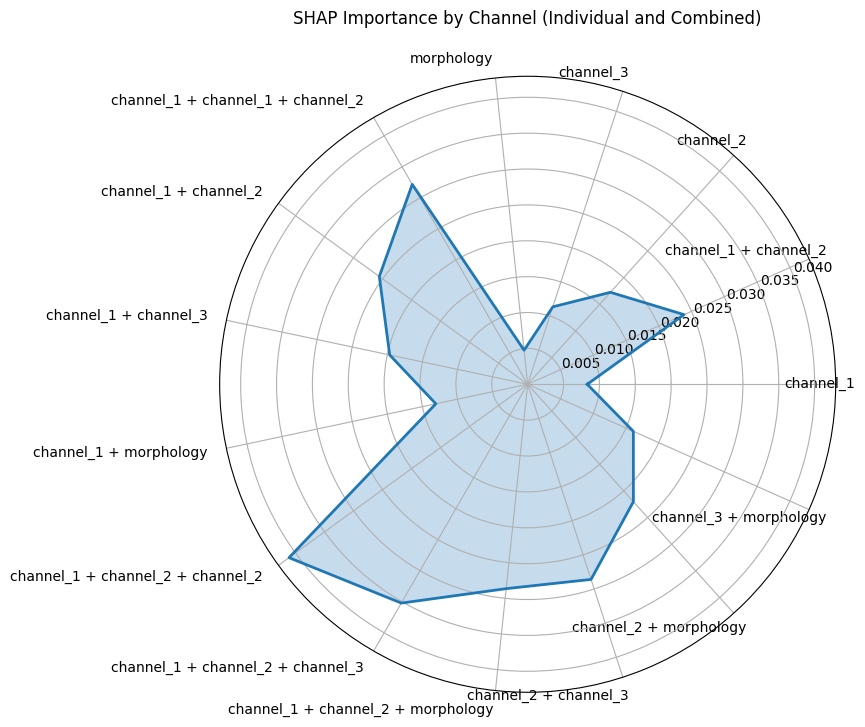

,object_label,plate,row_name,column_name,field,prcf,file_name,path_name,prc,cells_per_well,...,pathogen_channel_1_channel_3_M1_correlation_95,pathogen_channel_1_channel_3_M2_correlation_95,pathogen_channel_2_channel_3_M1_correlation_15,pathogen_channel_2_channel_3_M2_correlation_15,pathogen_channel_2_channel_3_M1_correlation_85,pathogen_channel_2_channel_3_M2_correlation_85,pathogen_channel_2_channel_3_M1_correlation_95,pathogen_channel_2_channel_3_M2_correlation_95,pathogen_prcfo_count,cv_predictions
0,101,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r10_c11,92,...,0.000000,0.000000,0.700896,0.721041,0.000000,0.000000,0.000000,0.000000,1.0,0
1,104,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r10_c11,92,...,0.002224,0.001375,0.781562,0.751003,0.025694,0.020279,0.000470,0.000349,1.0,0
2,107,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r10_c11,92,...,0.004971,0.003943,0.824009,0.766166,0.029448,0.020089,0.009793,0.006330,1.0,0
3,137,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r10_c11,92,...,0.000000,0.000000,0.756574,0.729944,0.027023,0.020488,0.000000,0.000000,1.0,0
4,138,pplate1,r10,c11,f10,pplate1_r10_c11_f10,plate1_J11_10,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r10_c11,92,...,0.000000,0.000000,0.826501,0.770436,0.073517,0.049407,0.012787,0.008092,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60811,4,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r9_c9,129,...,0.000662,0.000584,0.833220,0.781898,0.039290,0.022536,0.003286,0.001328,2.0,1
60812,73,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r9_c9,129,...,0.000000,0.000000,0.746353,0.777684,0.027406,0.025505,0.001731,0.000656,1.0,0
60813,75,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r9_c9,129,...,0.000313,0.000329,0.735061,0.736596,0.028893,0.022633,0.004980,0.003748,2.0,0
60814,79,pplate1,r9,c9,f9,pplate1_r9_c9_f9,plate1_I09_9,/nas_mnt/carruthers/Einar/tsg101_screen/TSG101...,pplate1_r9_c9,129,...,0.000000,0.000000,0.740277,0.732288,0.001253,0.000906,0.000000,0.000000,1.0,0


In [1]:
from spacr.ml import interperate_vision_model
%matplotlib inline

settings = {'src':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1',
           'scores':'/nas_mnt/carruthers/Einar/tsg101_screen/TSG101SCREEN_20240810_132824/plate1/datasets/241007_241003_tsg101_screen_plate1_maxvit_t_epoch_99_acc_99.0_channels_rgb_result.csv',
           'tables':['cell', 'nucleus', 'pathogen','cytoplasm'],
           'feature_importance':True,
           'permutation_importance':False,
           'shap':True,
           'save':False,
           'nuclei_limit':1000,
           'pathogen_limit':1000,
           'top_features':30,
           'shap_sample':True,
           'n_jobs':-1,
           'shap_approximate':True,
           'score_column':'cv_predictions'}

merged_df = interperate_vision_model(settings)
display(merged_df)